In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [68]:
pd.options.display.max_columns = None

In [69]:
df_listing = pd.read_csv('Data/listings_details.csv')
df_reviews = pd.read_csv('Data/reviews_Details.csv')
df_scrape = pd.read_csv('Data/Airbnb_Description.csv')
df_listing.head(5)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2265,https://www.airbnb.com/rooms/2265,20210210181232,2021-02-12,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,NaN,https://a0.muscache.com/pictures/4740524/63f82...,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,90%,f,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,NaN,78702,NaN,30.27750,-97.71398,Entire house,Entire home/apt,4,NaN,2 baths,2.0,2.0,"[""Free parking on premises"", ""Hair dryer"", ""Pa...",$200.00,7,180,7.0,7.0,180.0,180.0,7.0,180.0,NaN,t,13,13,42,131,2021-02-12,24,0,0,2009-03-17,2019-03-16,93.0,9.0,10.0,10.0,10.0,8.0,9.0,NaN,f,3,2,1,0,0.17
1,5245,https://www.airbnb.com/rooms/5245,20210210181232,2021-02-12,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,NaN,https://a0.muscache.com/pictures/5167505/b33b5...,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,90%,f,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,NaN,78702,NaN,30.27577,-97.71379,Private room in house,Private room,2,NaN,1 private bath,1.0,2.0,"[""Free parking on premises"", ""Hair dryer"", ""Br...",$114.00,30,60,30.0,30.0,60.0,60.0,30.0,60.0,NaN,t,0,0,0,0,2021-02-12,9,0,0,2009-03-19,2018-03-14,91.0,10.0,8.0,10.0,9.0,10.0,9.0,NaN,f,3,2,1,0,0.06
2,5456,https://www.airbnb.com/rooms/5456,20210210181232,2021-02-12,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,https://www.airbnb.com/users/show/8028,Sylvia,2009-02-16,"Austin, Texas, United States",I am a licensed Real Estate Broker and owner o...,within a few hours,100%,91%,t,https://a0.muscache.com/im/users/8028/profile_...,https://a0.muscache.com/im/users/8028/profile_...,East Downtown,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Austin, Texas, United States",78702,NaN,30.26112,-97.73448,Entire guesthouse,Entire home/apt,3,NaN,1 bath,1.0,2.0,"[""Hair dryer"", ""Dishes and silverware"", ""Air c...",$104.00,2,90,2.0,2.0,90.0,90.0,2.0,90.0,NaN,t,24,54,84,354,2021-02-12,543,20,3,2009-03-08,2021-02-01,97.0,10.0,10.0,10.0,10.0,10.0,9.0,NaN,f,1,1,0,0,3.74
3,5636,https://www.a

In [70]:
df_listing.shape

(10272, 74)

## Performing EDA Analysis

In [71]:
# Removing unnecessary columns
columns_to_remove = ['scrape_id','last_scraped','neighbourhood_group_cleansed','calendar_updated','license','bathrooms',
                     'picture_url','host_has_profile_pic','host_name','host_url','host_thumbnail_url','name',
                     'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
                     'minimum_nights_avg_ntm','maximum_nights_avg_ntm','has_availability','host_picture_url',
                     'number_of_reviews_l30d','number_of_reviews_ltm','calendar_last_scraped',
                     'calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
                     'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month',
                     'availability_30','availability_60','availability_365',
                     'neighbourhood','host_about',
                     'latitude','longitude'] 
df_listing.drop(columns_to_remove,axis=1,inplace=True)

In [72]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10272 entries, 0 to 10271
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           10272 non-null  int64  
 1   listing_url                  10272 non-null  object 
 2   description                  10064 non-null  object 
 3   neighborhood_overview        6545 non-null   object 
 4   host_id                      10272 non-null  int64  
 5   host_since                   10267 non-null  object 
 6   host_location                10247 non-null  object 
 7   host_response_time           6073 non-null   object 
 8   host_response_rate           6073 non-null   object 
 9   host_acceptance_rate         6850 non-null   object 
 10  host_is_superhost            10267 non-null  object 
 11  host_neighbourhood           8363 non-null   object 
 12  host_listings_count          10267 non-null  float64
 13  host_total_listi

### Renaming Columns

In [73]:
df_listing = df_listing.rename(columns={'neighbourhood_cleansed': 'zip_code'})

### Converting the columns data format

In [74]:
df_listing.first_review = pd.to_datetime(df_listing.first_review)
df_listing.last_review = pd.to_datetime(df_listing.last_review)
df_listing.host_since = pd.to_datetime(df_listing.host_since)

df_listing["Timeframe"] = (df_listing.last_review - df_listing.first_review).dt.days
df_listing.drop(['first_review','last_review'],axis=1,inplace=True)

In [75]:
# Filtering the prices and remove the highest ones due to SXSW festival
df_listing.price = df_listing.price.replace('[\$,]','',regex=True).astype(float)
df_listing = df_listing[df_listing.price<5200]

In [76]:
# Converting categories to numbers
df_listing.loc[:,'host_is_superhost'] = df_listing.host_is_superhost.map({'t':1,'f':0})
df_listing.loc[:,'instant_bookable'] = df_listing.instant_bookable.map({'t':1,'f':0})



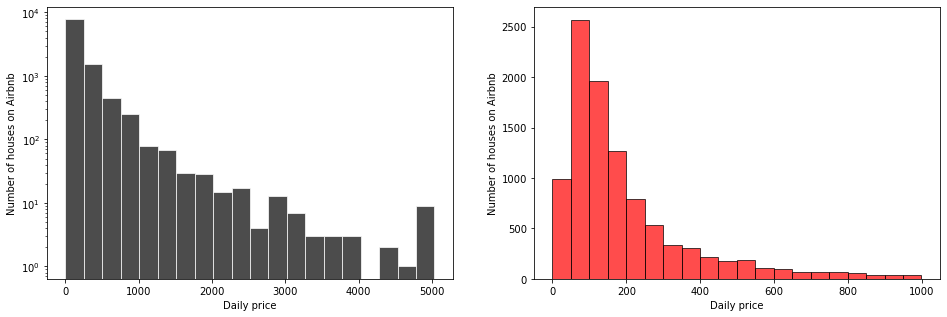

In [77]:
fig,axs = plt.subplots(1,2,figsize=(16,5))
axs[0].hist(df_listing.price,bins=20,color='k',alpha=0.7,edgecolor='w')
axs[0].set_yscale('log');
axs[0].set_xlabel('Daily price');
axs[0].set_ylabel('Number of houses on Airbnb');
axs[0].grid(b='None');
axs[0].grid(None);
axs[1].hist(df_listing.price[df_listing.price<1000],bins=20,color='r',alpha=0.7,edgecolor='k');
axs[1].set_xlabel('Daily price');
axs[1].set_ylabel('Number of houses on Airbnb');
df_listing = df_listing[df_listing.price<1500]

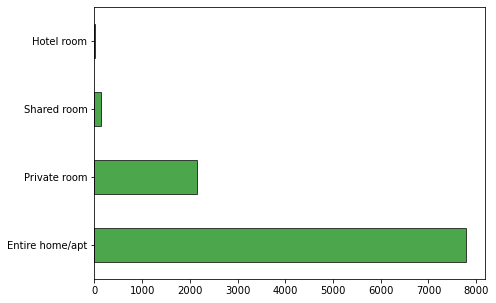

In [78]:
fig,axs = plt.subplots(figsize=(7,5))
df_listing.room_type.value_counts().plot(kind='barh',color='g',alpha=0.7,edgecolor='k');

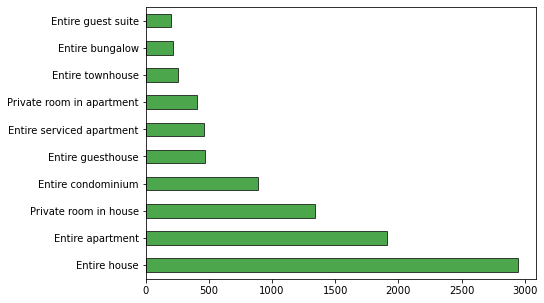

In [79]:
fig,ax = plt.subplots(figsize=(7,5))
df_listing.property_type.value_counts()[:10].plot(kind='barh',color='g',alpha=0.7,edgecolor='k');

In [80]:
#df_listing.info()

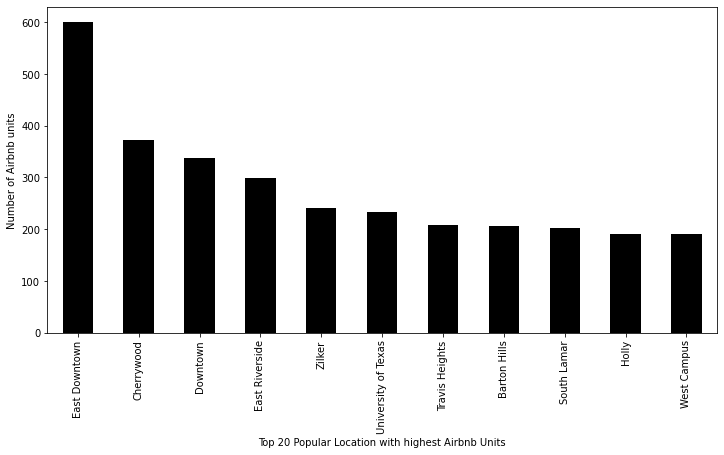

In [81]:
fig,ax = plt.subplots(figsize=(12,6));
ax = df_listing.host_neighbourhood.value_counts()[:11].plot.bar(color='k');
ax.set_ylabel('Number of Airbnb units');
ax.set_xlabel('Top 20 Popular Location with highest Airbnb Units');

In [82]:
dict_amenities = dict()
for lst in df_listing.amenities:
    for word in lst.replace('[','').replace('"','').replace(']','').replace(' ','').split(','):
        if word not in dict_amenities:
            dict_amenities[word] = 1
        else:
            dict_amenities[word] += 1

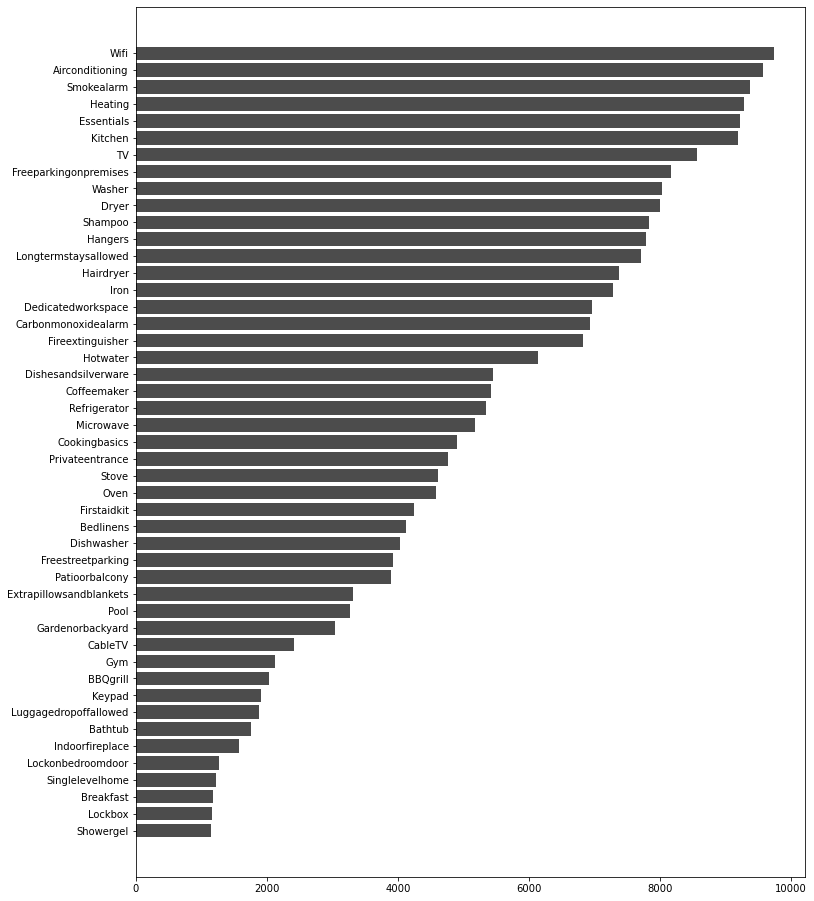

In [83]:
filtered_dict = {k:v for k,v in dict_amenities.items() if v>1000}
filtered_dict = {k:v for k,v in sorted(filtered_dict.items(),key=lambda item:item[1])}

fig,ax = plt.subplots(figsize=(12,16))
a= list(filtered_dict.keys())
b= filtered_dict.values()
# ax.bar(a,b)
plt.barh(a,b,color='k',alpha=0.7);

In [84]:
## Features to keep
# bbqgrill, gym, pool,private_entrance

# Most expensive house
# https://www.airbnb.com/rooms/46081394/photos?guests=1&adults=1
# https://www.airbnb.com/luxury/listing/36868497?source_impression_id=p3_1616965432_%2BtiLPpKVsNjbcXS8&guests=1&adults=1&check_in=2021-04-07&check_out=2021-04-10
#https://www.airbnb.com/rooms/46081476/photos?source_impression_id=p3_1616965591_2THtdQLDDHYaRava

Text(0.5, 0, 'Host Locations')

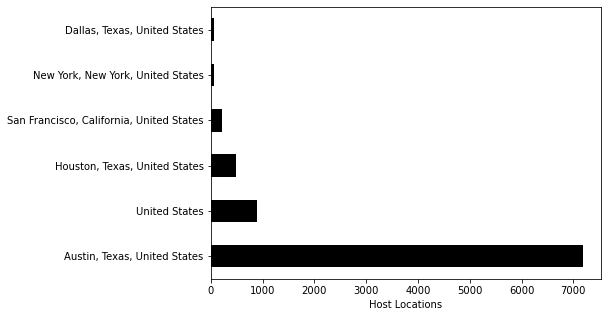

In [85]:
df_listing.host_location = df_listing.host_location.str.replace('US','United States')
fig,ax = plt.subplots(figsize=(7,5))
ax = df_listing.host_location.value_counts().head(6).plot(kind='barh',color='k')
ax.set_xlabel('Host Locations')

Text(0, 0.5, 'Median Price per Night')

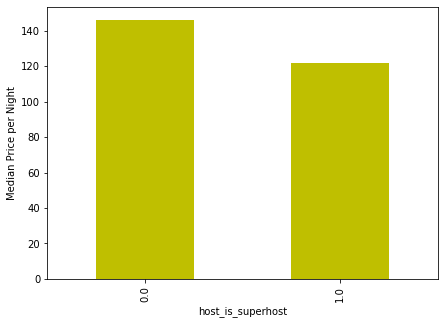

In [86]:
fig,ax = plt.subplots(figsize=(7,5));
df_listing.groupby('host_is_superhost').price.median().plot(kind='bar',color='y');
ax.set_ylabel('Median Price per Night')

In [87]:
df_listing.bedrooms = df_listing.bedrooms.fillna(0)

In [88]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10097 entries, 0 to 10271
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           10097 non-null  int64         
 1   listing_url                  10097 non-null  object        
 2   description                  9910 non-null   object        
 3   neighborhood_overview        6455 non-null   object        
 4   host_id                      10097 non-null  int64         
 5   host_since                   10092 non-null  datetime64[ns]
 6   host_location                10072 non-null  object        
 7   host_response_time           5953 non-null   object        
 8   host_response_rate           5953 non-null   object        
 9   host_acceptance_rate         6728 non-null   object        
 10  host_is_superhost            10092 non-null  float64       
 11  host_neighbourhood           8209 non-nul

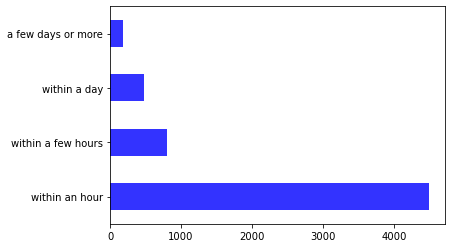

In [89]:
df_listing.host_response_time.value_counts().plot(kind='barh',color='b',alpha=0.8);

In [90]:
columns_to_remove2 = ['host_response_time','host_response_rate','host_neighbourhood'] 
df_listing.drop(columns_to_remove2,axis=1,inplace=True)

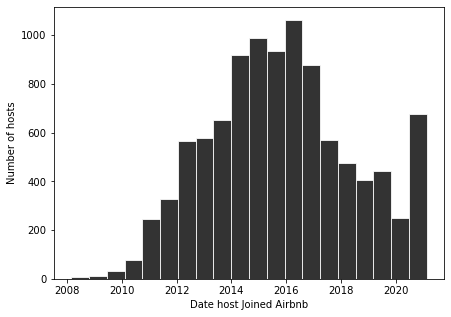

In [91]:
fig,ax = plt.subplots(figsize=(7,5))
df_listing.host_since.hist(bins=20,color='k',alpha=0.8,edgecolor='w')
ax.grid(None);
ax.set_xlabel('Date host Joined Airbnb');
ax.set_ylabel('Number of hosts');

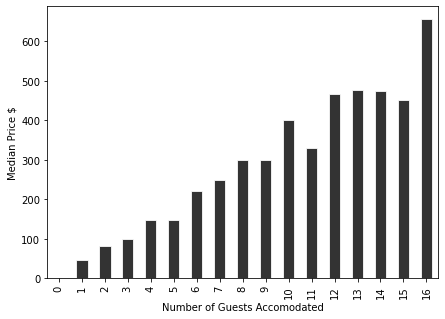

In [92]:
fig,ax = plt.subplots(figsize=(7,5))
ax = df_listing.groupby('accommodates').price.median().plot(kind='bar',color='k',alpha=0.8,edgecolor='w');
ax.set_xlabel('Number of Guests Accomodated');
ax.set_ylabel('Median Price $');

In [93]:
df_listing.room_type = df_listing.room_type.str.replace('Hotel room','Hotel_room')
df_listing.room_type = df_listing.room_type.str.replace('Private room','Private_room')
df_listing.room_type = df_listing.room_type.str.replace('Shared room','Shared_room')

dummies_room_type = pd.get_dummies(df_listing.room_type,prefix='room_type_',drop_first=True)

In [94]:
df_listing = pd.concat([df_listing,dummies_room_type],axis=1)
df_listing.drop('room_type',axis=1,inplace=True)

In [95]:
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('1 private bath','1 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('1 shared bath','0.5 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('1.5 shared baths','0.75 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('2 shared baths','1 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('Half-bath','0.5 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('4 shared baths','2 baths')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('2.5 shared baths','1.25 baths')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('3 shared baths','1.5 baths')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('Private half-bath','0.5 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('0 shared baths','0 bath')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('2 bath','2 baths')
df_listing.bathrooms_text = df_listing.bathrooms_text.str.replace('0 baths','0 bath')
df_listing = df_listing[df_listing.bathrooms_text.notnull()]
df_listing['bathrooms'] = df_listing.bathrooms_text.apply(lambda x:float(x.split(' ')[0]))
df_listing.drop('bathrooms_text',axis=1,inplace=True)

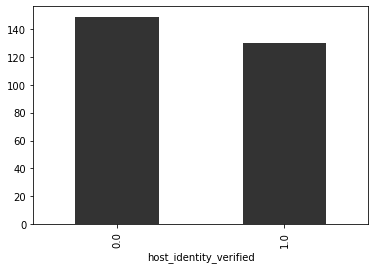

In [96]:
df_listing.loc[:,'host_identity_verified'] = df_listing.host_identity_verified.map({'t':1,'f':0});
df_listing.groupby('host_identity_verified').price.median().plot(kind='bar',color='k',alpha=0.8);

In [97]:
df_listing.drop('host_identity_verified',axis=1,inplace=True)
df_listing.drop('description',axis=1,inplace=True)
df_listing.drop('neighborhood_overview',axis=1,inplace=True)

In [98]:
property_type = ['Entire house','Entire apartment','Private room in house','Entire condominium','Entire guesthouse',             
'Entire serviced apartment','Private room in apartment','Entire townhouse','Entire bungalow','Entire guest suite']
df_listing.property_type = df_listing.property_type.apply(lambda x: 'other' if x not in property_type else x)
dummies_property_type = pd.get_dummies(df_listing.property_type,prefix='property_type',drop_first=True)
df_listing = pd.concat([df_listing,dummies_property_type],axis=1)
df_listing.drop('property_type',axis=1,inplace=True)

df_listing = df_listing.rename(columns={'neighbourhood_cleansed': 'zip_code',
                                        'property_type_Entire bungalow':'property_type_Entire_bungalow',                    
                                        'property_type_Entire condominium':'property_type_Entire_condominium',                
                                        'property_type_Entire guest suite':'property_type_Entire_guest_suite',             
                                        'property_type_Entire guesthouse': 'property_type_Entire_guesthouse',            
                                        'property_type_Entire house':'property_type_Entire_house',                      
                                        'property_type_Entire serviced apartment':'property_type_Entire_serviced_apartment',       
                                        'property_type_Entire townhouse':'property_type_Entire_townhouse',                  
                                        'property_type_Private room in apartment':'property_type_Private_room_in_apartment',        
                                        'property_type_Private room in house': 'property_type_Private_room_in_house'    
                                       })

In [99]:
df_listing['pool'] = df_listing.amenities.apply(lambda x: 1 if 'pool' in x.lower() else 0)
df_listing['tv'] = df_listing.amenities.apply(lambda x: 1 if 'tv' in x.lower() else 0)
df_listing['washer'] = df_listing.amenities.apply(lambda x: 1 if 'washer' in x.lower() else 0)
df_listing['dryer'] = df_listing.amenities.apply(lambda x: 1 if 'dryer' in x.lower() else 0)
df_listing['balcony'] = df_listing.amenities.apply(lambda x: 1 if 'balcony' in x.lower() else 0)
df_listing['entrance'] = df_listing.amenities.apply(lambda x: 1 if 'entrance' in x.lower() else 0)
df_listing['bbq'] = df_listing.amenities.apply(lambda x: 1 if 'bbq' in x.lower() else 0)

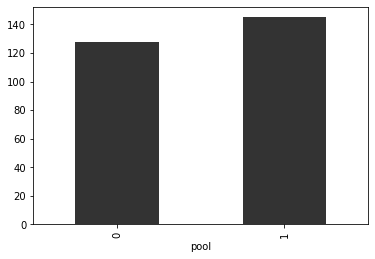

In [100]:
df_listing.groupby('pool').price.median().plot(kind='bar',color='k',alpha=0.8);

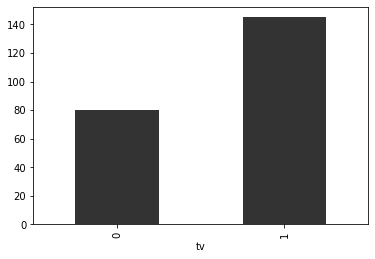

In [101]:
df_listing.groupby('tv').price.median().plot(kind='bar',color='k',alpha=0.8);

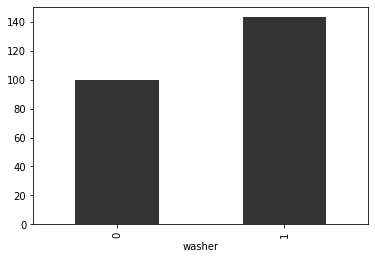

In [102]:
df_listing.groupby('washer').price.median().plot(kind='bar',color='k',alpha=0.8);

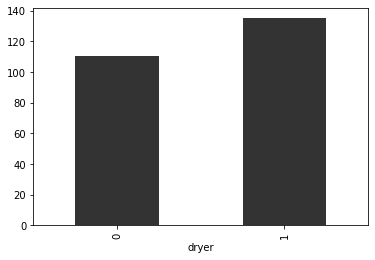

In [103]:
df_listing.groupby('dryer').price.median().plot(kind='bar',color='k',alpha=0.8);

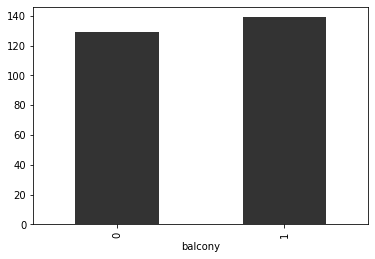

In [104]:
df_listing.groupby('balcony').price.median().plot(kind='bar',color='k',alpha=0.8);

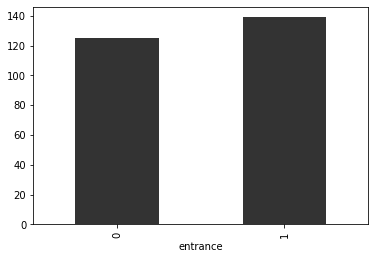

In [105]:
df_listing.groupby('entrance').price.median().plot(kind='bar',color='k',alpha=0.8);

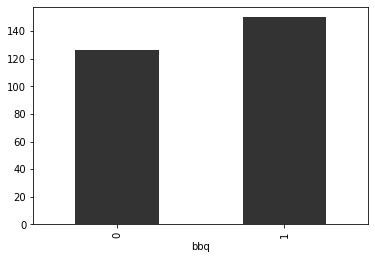

In [106]:
df_listing.groupby('bbq').price.median().plot(kind='bar',color='k',alpha=0.8);

In [107]:
df_listing.beds.fillna(value=0,inplace=True)
df_listing = df_listing[df_listing.host_is_superhost.notna()]
df_listing.Timeframe.fillna(value=0,inplace=True)

In [108]:
df_listing.review_scores_rating.fillna(90,inplace=True)

In [109]:
df_listing.host_acceptance_rate = df_listing.host_acceptance_rate.replace('[%]','',regex=True).astype(float)

In [110]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10076 entries, 0 to 10271
Data columns (total 50 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   id                                       10076 non-null  int64         
 1   listing_url                              10076 non-null  object        
 2   host_id                                  10076 non-null  int64         
 3   host_since                               10076 non-null  datetime64[ns]
 4   host_location                            10056 non-null  object        
 5   host_acceptance_rate                     6724 non-null   float64       
 6   host_is_superhost                        10076 non-null  float64       
 7   host_listings_count                      10076 non-null  float64       
 8   host_total_listings_count                10076 non-null  float64       
 9   host_verifications                     

## Machine Learning Section

### Linear Regression

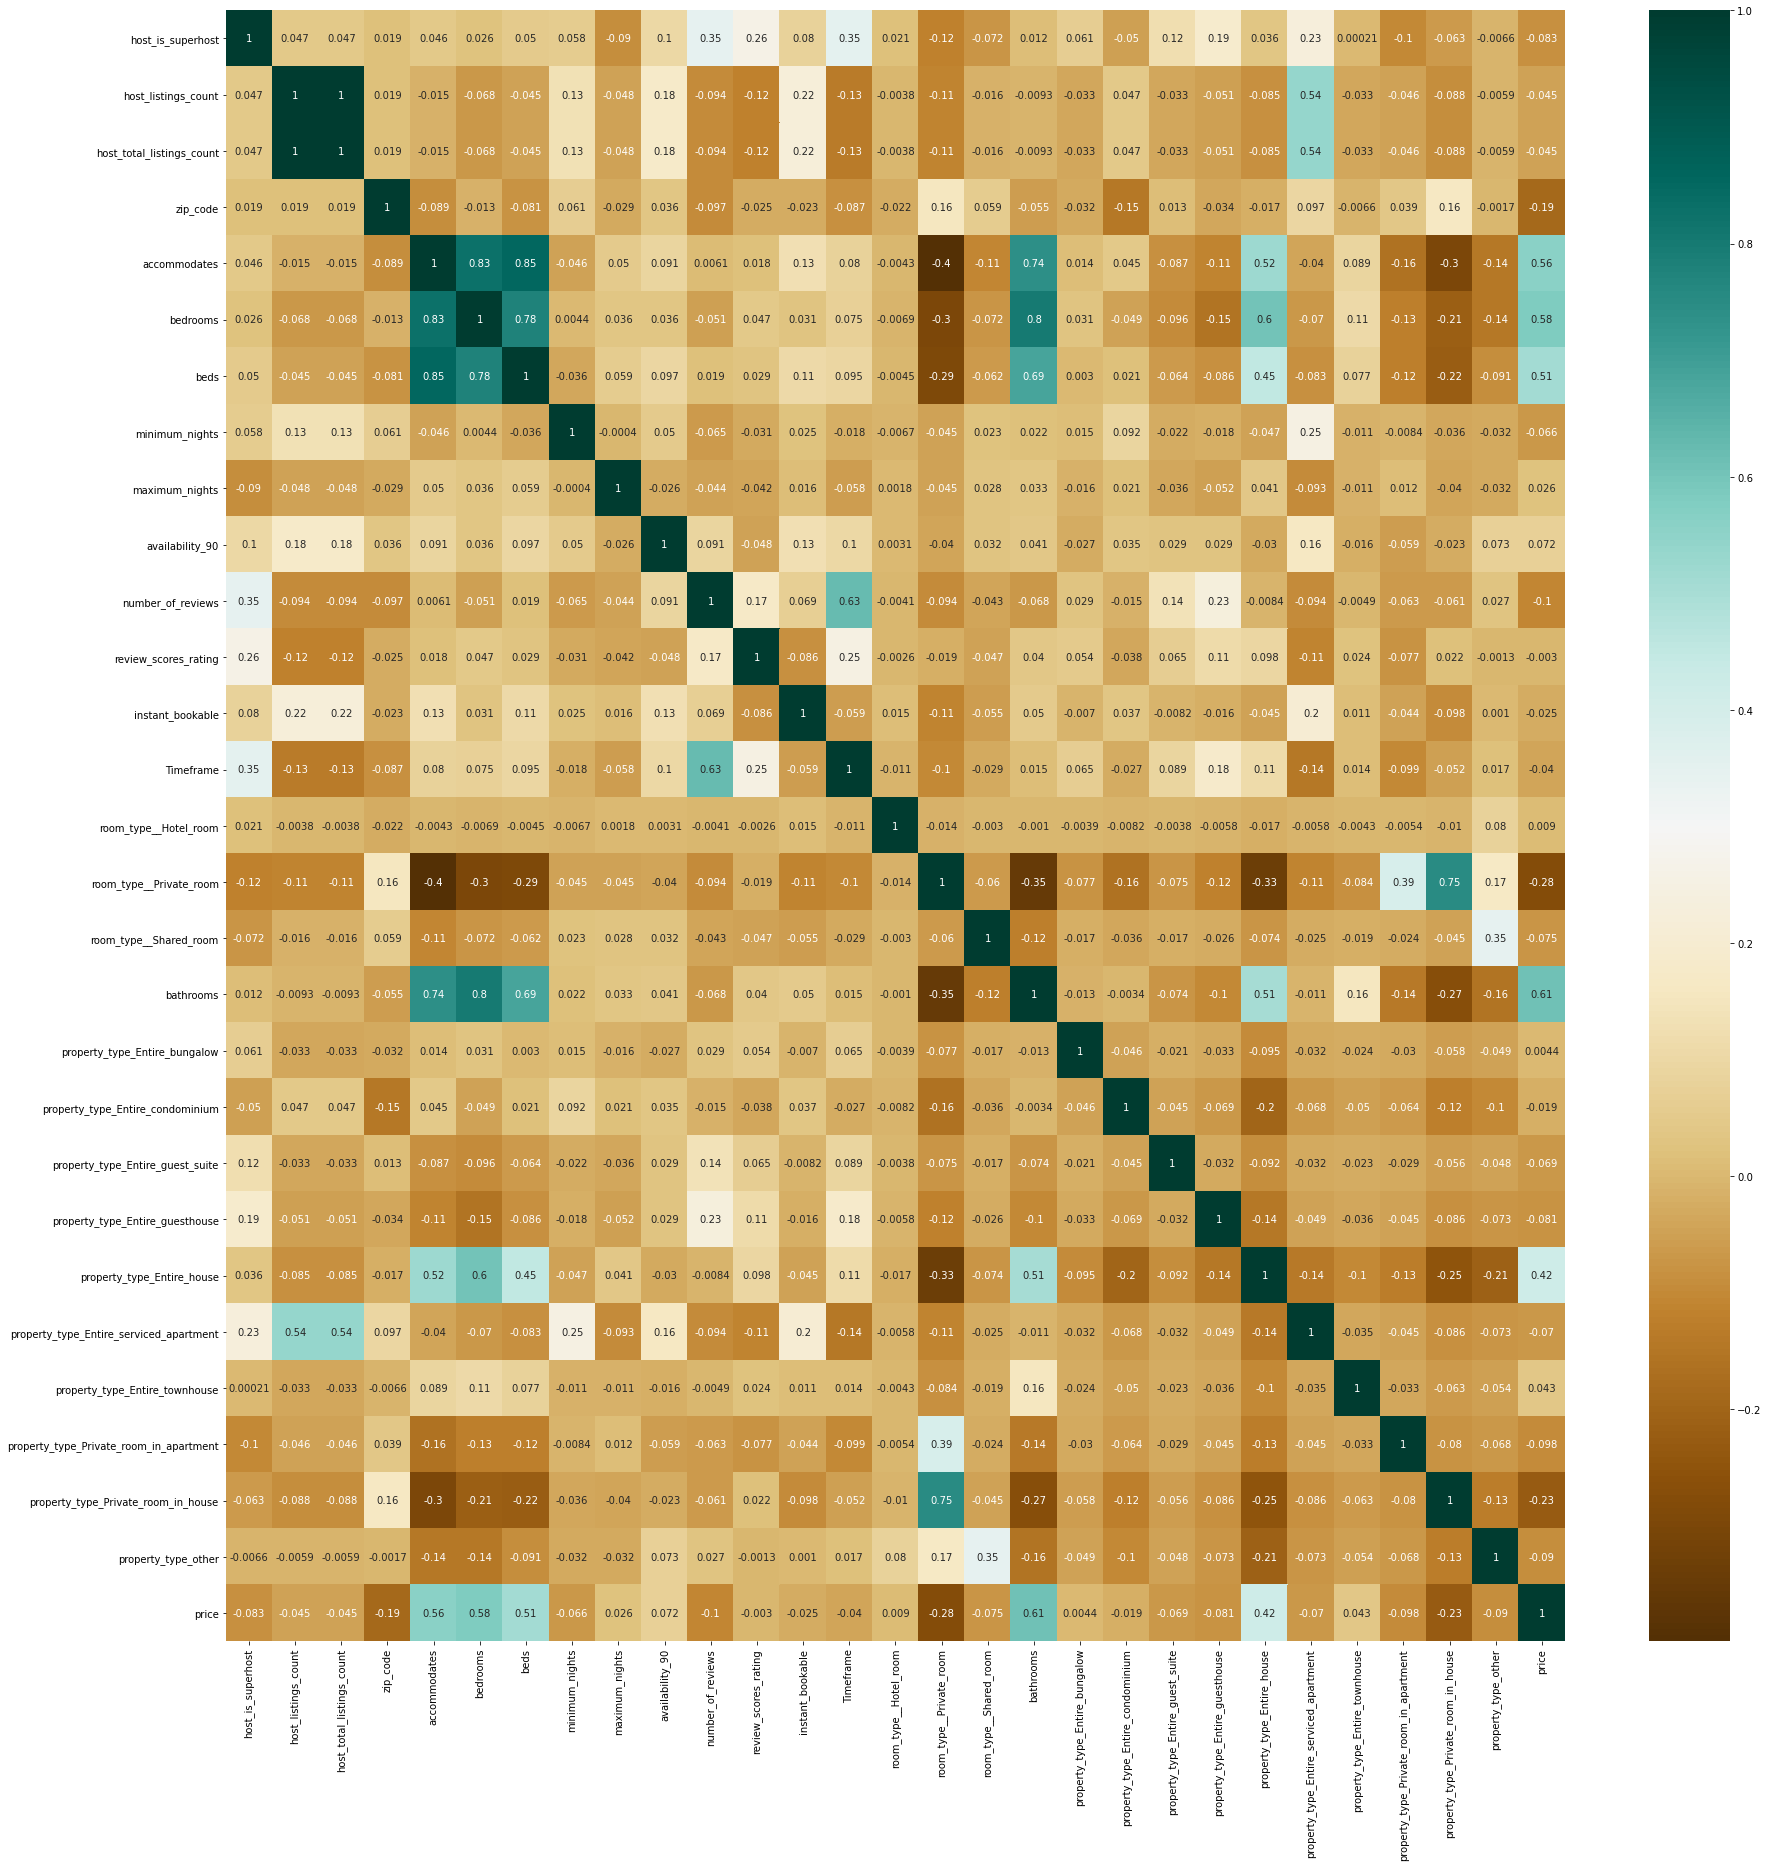

In [135]:
features_test =['host_is_superhost', 'host_listings_count',
           'host_total_listings_count',  'zip_code',
           'accommodates', 'bedrooms', 'beds',
           'minimum_nights', 'maximum_nights', 'availability_90',
           'number_of_reviews', 'review_scores_rating', 'instant_bookable', 'Timeframe',
           'room_type__Hotel_room', 'room_type__Private_room',
           'room_type__Shared_room', 'bathrooms', 'property_type_Entire_bungalow',
           'property_type_Entire_condominium', 'property_type_Entire_guest_suite',
           'property_type_Entire_guesthouse', 'property_type_Entire_house',
           'property_type_Entire_serviced_apartment',
           'property_type_Entire_townhouse',
           'property_type_Private_room_in_apartment',
           'property_type_Private_room_in_house', 'property_type_other','price']
X_Corr = df_listing[features_test];
fig,ax = plt.subplots(figsize=(30,30));
sns.heatmap(X_Corr.corr(),annot=True,cmap='BrBG');

In [111]:
features =['host_is_superhost', 'host_listings_count',
           'host_total_listings_count',  'zip_code',
           'accommodates', 'bedrooms', 'beds',
           'minimum_nights', 'maximum_nights', 'availability_90',
           'number_of_reviews', 'review_scores_rating', 'instant_bookable', 'Timeframe',
           'room_type__Hotel_room', 'room_type__Private_room',
           'room_type__Shared_room', 'bathrooms', 'property_type_Entire_bungalow',
           'property_type_Entire_condominium', 'property_type_Entire_guest_suite',
           'property_type_Entire_guesthouse', 'property_type_Entire_house',
           'property_type_Entire_serviced_apartment',
           'property_type_Entire_townhouse',
           'property_type_Private_room_in_apartment',
           'property_type_Private_room_in_house', 'property_type_other', 'pool',
           'tv', 'washer', 'dryer', 'balcony', 'entrance', 'bbq']

X = df_listing[features]
y= df_listing.price
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [112]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [113]:
mean_squared_error(y_train,lr.predict(X_train))
r2_score(y_train,lr.predict(X_train))

0.470712655597611

In [145]:
np.sqrt(mean_squared_error(y_test,lr.predict(X_test)))

157.45315147304214

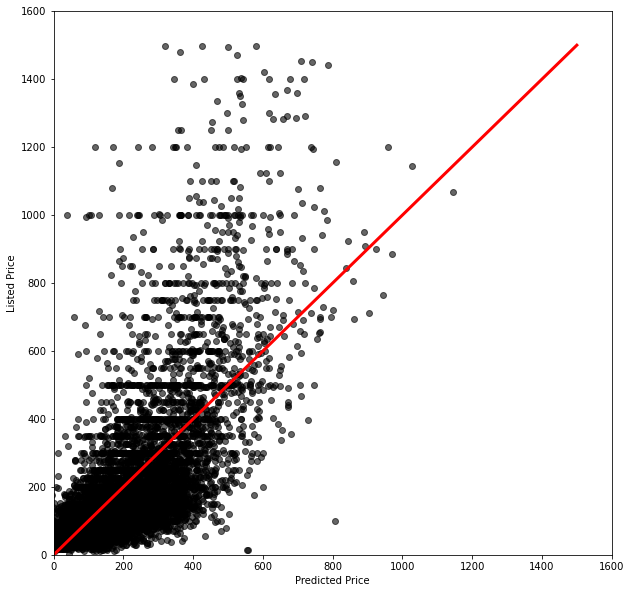

In [140]:
X_trial=[0,1500]
y_trial=[0,1500]
fig,ax = plt.subplots(figsize=(10,10));
ax.scatter(lr.predict(X_train),y_train,c='k',alpha=0.6);
ax.plot(X_trial,y_trial,'r',lw=3);
ax.set_xlim([0,1600]);
ax.set_ylim([0,1600]);
ax.set_xlabel('Predicted Price');
ax.set_ylabel('Listed Price');

In [146]:
ss = StandardScaler()
ss.fit(X_train)
X_train_s = ss.transform(X_train)
X_test_s = ss.transform(X_test)

In [151]:
ls = Lasso(alpha=0.1)
ls.fit(X_train_s,y_train)


Lasso(alpha=0.1)

In [154]:
y_predict = ls.predict(X_test_s)

In [ ]:
ls.

### Random Forest

In [155]:
rf = RandomForestRegressor(n_estimators=1000,max_depth=10,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, n_estimators=1000, n_jobs=-1)

In [157]:
y_predicted = rf.predict(X_test)

In [158]:
r2_score(y_test,y_predicted)

0.6134301429240994

### XGBoost 

In [119]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [120]:
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

In [121]:
r2_score(training_preds_xgb_reg,y_train)

0.8704614316440143

In [122]:
r2_score(val_preds_xgb_reg,y_test)

0.45895062171937206

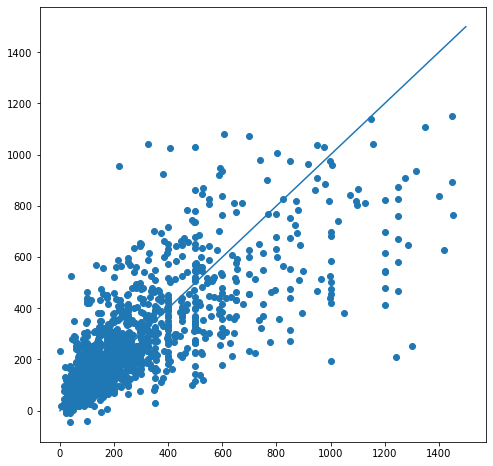

In [125]:
XX = [0,1500]
yy = [0,1500]
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(y_test,val_preds_xgb_reg)
ax.plot(XX,yy)